In [0]:
import pandas as pd
import seaborn as sns

In [0]:
aircraft_types = pd.read_excel("/content/aircraft_types.xlsx", encoding='utf8')
airlines = pd.read_excel("/content/airlines.xlsx", encoding='utf8')
demand = pd.read_excel("/content/demand.xlsx", encoding='utf8')
hangars = pd.read_excel("/content/hangars.xlsx", encoding='utf8')
maintenance_type = pd.read_excel("/content/maintenance_types.xlsx", encoding='utf8')

aircraft_types.columns = ['aircraft', 'length', 'width']
airlines.columns = ['airline', 'start', 'stop', 'penalty']
demand.columns = ['airline', 'aircraft', 'TO', 'need', 'duration', 'must']
hangars.columns = ['airport', 'width', 'depth']
maintenance_type.columns = ['TO', 'aircraft', 'DME', 'SVO', 'VKO']

hangars['airport'] = hangars['airport'].map({'DME (Домодедово-Москва)': 'DME', 'SVO (Шереметьево-Москва)': 'SVO', 'VKO (Внуково-Москва)': 'VKO'})
aircraft_types['max_width'] = aircraft_types[['length', 'width']].max(axis=1)
aircraft_types['min_width'] = aircraft_types[['length', 'width']].min(axis=1)
aircraft_types.drop(columns=['length', 'width'], axis=1, inplace=True)
maintenance_type['mean_price'] = maintenance_type[['DME', 'SVO', 'VKO']].mean(axis=1).astype(int)

In [136]:
# Зависимость средней цены от аэропорта
maintenance_type[['DME', 'SVO', 'VKO']].mean()

DME    26291.666667
SVO    28600.000000
VKO    30000.000000
dtype: float64

In [137]:
# Кол-во самолетов
demand.groupby(['aircraft'])['need'].agg('sum').sort_values()[::-1]

aircraft
A320         51
737-800      37
A321         36
737-200      24
737-300      22
Ан-24        20
Ту-154М      16
Ил-96-300     9
Ан-124        9
Ил-96-400     8
A319          8
Name: need, dtype: int64

In [138]:
# Техническое обслуживание по времени
demand.groupby(['TO'])['duration'].agg('mean').sort_values()[::-1]

TO
Redelivery    62.400000
D-Check       45.181818
C-Check       35.838710
Painting      12.576923
Name: duration, dtype: float64

In [139]:
# Зависимость тип ВС и ТО на время  
ac_to_time = demand.groupby(['aircraft', 'TO'])['duration'].agg('mean')
ac_to_time = ac_to_time.reset_index()
ac_to_time.head()

aircraft        TO   duration
0  737-200   C-Check  27.333333
1  737-200   D-Check  43.000000
2  737-200  Painting   8.666667
3  737-300   C-Check  31.500000
4  737-300   D-Check  44.500000

In [140]:
# Цена за метр площади самолета. Дневная выручка за самолет этой модели к занимаемому пространству
# Меньше места - больше выручка
plus_data = maintenance_type.merge(aircraft_types, on=['aircraft'])
plus_data.drop(columns=['DME', 'VKO', 'SVO'], inplace=True)
plus_data['area'] = plus_data['max_width'] * plus_data['min_width']
plus_data['mean_price_per_area'] = plus_data['mean_price']/plus_data['area']
plus_data.sort_values(by='mean_price_per_area', ascending=False).head()

TO aircraft  mean_price  ...  min_width       area  mean_price_per_area
26     D-Check  737-300       49000  ...      28.88   960.2600            51.027847
23     D-Check  737-200       43000  ...      28.35   865.5255            49.680801
29     D-Check  737-800       57500  ...      34.32  1354.6104            42.447629
16  Redelivery     A320       52500  ...      34.10  1281.1370            40.979224
20  Redelivery     A321       62000  ...      34.10  1517.7910            40.848839

[5 rows x 7 columns]

In [141]:
# Цена за день обслуживание самолета. Дневная выручка за самолет этой модели к занимаемому времени.
# Может быть полезным признаком
plus_data = plus_data.merge(ac_to_time, on=['aircraft', 'TO'])
plus_data['area'] = plus_data['max_width'] * plus_data['min_width']
plus_data['mean_price_per_duration'] = plus_data['mean_price']/plus_data['duration']

plus_data.sort_values(by='mean_price_per_duration', ascending=False).head()

TO aircraft  ...   duration  mean_price_per_duration
27  Painting  737-300  ...   9.333333              1857.107143
24  Painting  737-200  ...   8.666667              1730.769231
30  Painting  737-800  ...  12.333333              1621.621622
17  Painting     A320  ...  11.000000              1545.454545
21  Painting     A321  ...  13.200000              1464.621212

[5 rows x 9 columns]

In [142]:
# Выручка самолета. Как признак только для финального суммирования.
plus_data['total_price_in_millions'] = plus_data['mean_price'] * plus_data['duration'] /1000000
plus_data.sort_values(by='total_price_in_millions', ascending=False).head()

TO aircraft  ...  mean_price_per_duration  total_price_in_millions
8      C-Check   Ан-124  ...               800.000000                 4.500000
20  Redelivery     A321  ...               920.792079                 4.174667
16  Redelivery     A320  ...               875.000000                 3.150000
19     D-Check     A321  ...               952.095808                 2.950333
29     D-Check  737-800  ...              1437.500000                 2.300000

[5 rows x 10 columns]

In [143]:
"""
1)efficiency.Эффективность цены. Отдается предпочтение [макс цена за кв.м] на [продолжительность].
 Чтобы один один раз приехал и долго стоял (не было текучести) + много денег за мало места

2) efficiency_2. Эффективность оборота. 
Защита от ухода большого заказа (по цене) и простаивания места => недополучена прибыль.
"""

plus_data['efficiency'] = plus_data['duration'] * plus_data['mean_price_per_area']
plus_data['efficiency_2'] = plus_data['mean_price_per_area'] * plus_data['mean_price_per_duration']
plus_data.sort_values(by='efficiency', ascending=False)

TO   aircraft  ...   efficiency  efficiency_2
20  Redelivery       A321  ...  2750.488484  37613.287278
16  Redelivery       A320  ...  2458.753435  35856.820933
26     D-Check    737-300  ...  2270.739175  56187.965946
23     D-Check    737-200  ...  2136.274437  49680.800855
19     D-Check       A321  ...  1943.833725  33246.394164
12  Redelivery       A319  ...  1884.840166  32796.218881
29     D-Check    737-800  ...  1697.905169  61018.467007
11     D-Check       A319  ...  1369.217224  33802.550210
15     D-Check       A320  ...  1302.553903  41218.594629
25     C-Check    737-300  ...  1049.715702  33853.265270
28     C-Check    737-800  ...   918.960414  33842.043074
22     C-Check    737-200  ...   915.821275  35548.684219
8      C-Check     Ан-124  ...   888.444886   9476.745449
18     C-Check       A321  ...   799.583078  27499.046231
14     C-Check       A320  ...   708.355156  30910.043188
10     C-Check       A319  ...   521.105444  36372.601968
6      C-Check      Ан-24  ...   512.315959   5503.394093
2      C-Check  Ил-96-400  ...   357.007772   2789.123215
0      C-Check  Ил-96-300  ...   305.136697   2772.433147
4      C-Check    Ту-154М  ...   294.596766   2581.561176
30    Painting    737-800  ...   182.094178  23942.258551
13    Painting       A319  ...   181.984568  11323.484213
27    Painting    737-300  ...   168.469651  33521.377655
21    Painting       A321  ...   168.136193  18655.745023
24    Painting    737-200  ...   150.197770  29995.116795
17    Painting       A320  ...   145.964093  20507.351886
9     Painting     Ан-124  ...   128.330928   5338.566603
7     Painting      Ан-24  ...    96.054876   8695.930937
5     Painting    Ту-154М  ...    65.048967   3464.146194
3     Painting  Ил-96-400  ...    62.450339   1873.510172
1     Painting  Ил-96-300  ...    56.405243   1740.902565

[31 rows x 12 columns]

In [0]:
add = airlines.merge(demand)
df = pd.DataFrame(columns=add.columns)
for _, row in add.iterrows():
  try:
    m = int(row['must'])
  except ValueError:
    m = 0
  n = row['need']-m
  for i in range(m):
    row['need']=1
    row['must']=1
    df = df.append(row)
  for i in range(n):
    row['need']=1
    row['must']=0
    df = df.append(row)

df = df.drop(columns=['need'], axis=1)
d = {1: True, 0: False}
df['must'] = df['must'].map(d)

In [0]:
df = df.merge(plus_data_without_duration, on=['aircraft', 'TO'])

#пересчет с примерных на точные данные
df['mean_price_per_duration'] = df['mean_price']/df['duration']
df['total_price'] = df['mean_price'] * df['duration']

#добавление новых фич
df['real_penalty'] = df['penalty'] * df['duration'] * df['mean_price']

"""
1)efficiency.Эффективность цены. Отдается предпочтение [макс цена за кв.м] на [продолжительность].
 Чтобы один один раз приехал и долго стоял (не было текучести) + много денег за мало места

2) efficiency_2. Эффективность оборота. 
Защита от ухода большого заказа (по цене) и простаивания места => недополучена прибыль.

3) efficiency_3. Эффективность цены + защита от штрафонов и невыполнения обязательного минимума.
"""
df['efficiency'] = df['duration'] * df['mean_price_per_area']
df['efficiency_2'] = df['mean_price_per_area'] * df['mean_price_per_duration']
df['efficiency_3'] = df['duration'] * df['mean_price_per_area'] * df['real_penalty'] + (df['must']*10000000)

In [0]:
df.to_csv('sub1.csv')

In [125]:
df = df.sort_values(by='efficiency_3', ascending=False).head(20)
df

TO aircraft  mean_price  ...  total_price  real_penalty  efficiency_3
135  Redelivery     A321       62000  ...      3844000    2.6908e+06    6.8248e+09
91   Redelivery     A320       52500  ...      3150000     2.205e+06   5.43155e+09
92   Redelivery     A320       52500  ...      3150000     2.205e+06   5.43155e+09
93   Redelivery     A320       52500  ...      3150000     2.205e+06   5.42155e+09
136  Redelivery     A321       62000  ...      4340000     1.736e+06   4.97395e+09
132     D-Check     A321       53000  ...      2756000    1.9292e+06   3.51304e+09
133     D-Check     A321       53000  ...      3445000     1.378e+06   3.12771e+09
137  Redelivery     A321       62000  ...      4340000        868000   2.49198e+09
221     D-Check  737-800       57500  ...      2300000        920000   1.57207e+09
220     D-Check  737-800       57500  ...      2300000        920000   1.57207e+09
65      D-Check     A319       39500  ...      1580000     1.106e+06   1.52435e+09
66      D-Check     A319       39500  ...      1580000     1.106e+06   1.52435e+09
89      D-Check     A320       44500  ...      1557500   1.09025e+06   1.33544e+09
67   Redelivery     A319       43500  ...      2175000        652500   1.23986e+09
54      C-Check   Ан-124       60000  ...      4200000      1.26e+06   1.04481e+09
53      C-Check   Ан-124       60000  ...      4200000      1.26e+06   1.04481e+09
90      D-Check     A320       44500  ...      1780000        712000   9.89246e+08
134     D-Check     A321       53000  ...      2650000        530000   9.25358e+08
56      C-Check   Ан-124       60000  ...      4800000        960000   9.09768e+08
55      C-Check   Ан-124       60000  ...      4800000        960000   9.09768e+08

[20 rows x 20 columns]

In [173]:
# Выручка. Просумировать поле цена закрытых тасков
proceeds = new[new['is_close']==True]['total_price'].sum()

# Расходы на уплату штрафов по не закрытым необязательным заданиям
costs = new[(new['is_close']==False) & (new['must']==False)]['real_penalty'].sum()

# Есть ли провалы по не закрытым обязательным заданиям (минимум заданий)
fails = new[(new['is_close']==False) & (new['must']==True)]['real_penalty'].sum()

# Прибыль как разница между вырочкой и расходов на штрафы
profit = proceeds-costs
proceeds, costs, fails, profit

(62097500, 0, 0, 62097500)

In [226]:
df['is_penalty'] = (df['must']==False) & (df['prod_stop']>df['stop'])
df['is_must_penalty'] = (df['must']==True) & (df['prod_stop']>df['stop'])

# Выручка. Просумировать поле цена закрытых тасков
proceeds = new[new['is_close']==True]['total_price'].sum()

# Расходы на уплату штрафов по не закрытым необязательным заданиям
costs = new[(df['must']==False) & (df['prod_stop']>df['stop'])]['real_penalty'].sum()

# Есть ли провалы по не закрытым обязательным заданиям (минимум заданий)
fails = new[(df['must']==True) & (df['prod_stop']>df['stop'])]['real_penalty'].sum()

# Прибыль как разница между вырочкой и расходов на штрафы
profit = proceeds-((costs+fails)*2)
million = 1000000
print("Выручка (в миллионах): ", proceeds /million)
print("Штрафы: (в миллионах):", (costs+fails)*2 /million)
print("Прибыль: (в миллионах): ", profit/million)
print("Процент от максимальной выручки (%): ", round(profit/proceeds, 5)*100)

Выручка (в миллионах):  62.0975
Штрафы: (в миллионах): 12.213
Прибыль: (в миллионах):  49.8845
Процент от максимальной выручки (%):  80.333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [176]:
e = pd.DataFrame(['DME', 'SVO', 'VKO']).sample(n=1).iloc[0].iloc[0]
e


'VKO'

In [199]:
random.choice(['DME', 'SVO', 'VKO'])

'DME'

In [0]:
random.choice(['DME', 'SVO', 'VKO'])

In [203]:
df.shape

(240, 25)

In [205]:
len(df)

240

In [206]:
for i in range(len(df)):
  df['prod_airport'].iloc[i] = random.choice(['DME', 'SVO', 'VKO'])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [208]:
df.head(10)

airline      start       stop  ...  prod_stop is_open is_close
0        C7 2020-09-01 2020-11-30  ... 2020-11-14    True     True
1        C7 2020-09-01 2020-11-30  ... 2020-11-03    True     True
2        C7 2020-09-01 2020-11-30  ... 2020-11-04    True     True
3        C7 2020-09-01 2020-11-30  ... 2020-11-08    True     True
4        C7 2020-09-01 2020-11-30  ... 2020-11-16    True     True
5  Аэрофлот 2020-08-15 2020-11-30  ... 2020-11-06    True     True
6  Аэрофлот 2020-08-15 2020-11-30  ... 2020-11-08    True     True
7  Аэрофлот 2020-08-15 2020-11-30  ... 2020-11-05    True     True
8  Аэрофлот 2020-08-15 2020-11-30  ... 2020-10-27    True     True
9  Аэрофлот 2020-08-15 2020-11-30  ... 2020-10-26    True     True

[10 rows x 25 columns]

In [0]:
import datetime
import secrets
import random

df['prod_start']= df['start'] + df['start'].map(lambda x: datetime.timedelta(days=int(np.random.random(1)[0]*30)))
df['prod_stop'] = df['prod_start'] + datetime.timedelta(new['duration'].iloc[0])
df['is_open'] = True
df['is_close'] = True

In [0]:
df.sort_values(by='efficiency_3', ascending=False).head()
df.to_csv('sub5.csv', encoding='utf8')
df.to_excel('sub5.xlsx', encoding='utf8')


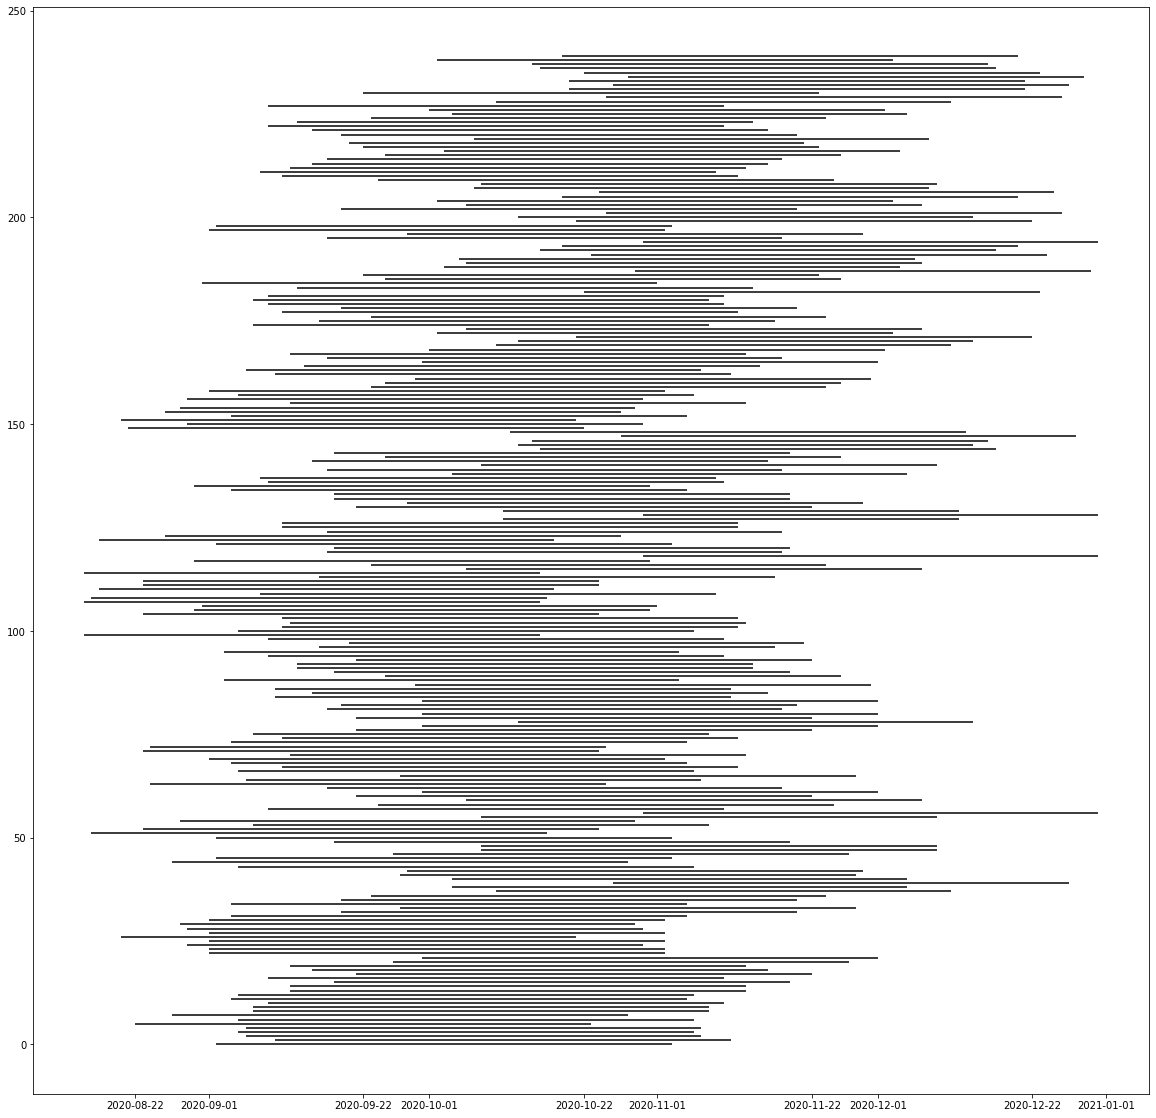

In [212]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dt



fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
ax = ax.xaxis_date()
ax = plt.hlines(df.index, dt.date2num(df.prod_start), dt.date2num(df.prod_stop))

In [0]:
df.to_excel('sub4.xlsx', encoding='utf8')

In [129]:
b = pd.date_range(start='8/14/2020', end='8/20/2020')
np.random.choice(b, size=1)

#dates_d = pd.date_range(df['start'], df['stop'], freq='D')
df['prod_airport'] = np.random.choice(['DME', 'SVO', 'VKO'])
df['prod_start'] = pd.Timestamp(year=2017, month=1, day=1, hour=12)
df['prod_start'] = pd.date_range(start=df['start'], end=df['stop'], freq='D')[np.random.randint(0, len(pd.date_range(start=df['start'], end=df['stop']))-1)]
df['prod_stop'] = df['prod_start'] + timedelta(df=new['duration'])
df['is_open'] = True
df['is_close'] = True


TypeError: ignored

In [0]:
df.to_csv('sub3.csv', encoding='utf8')
df.to_excel('sub3.xlsx', encoding='utf8')

In [0]:
import numpy as np
import pandas as pd
def random_dates(start, end, n=10):
    start_u = start.value//10**9
    end_u = end.value//10**9
    return pd.to_datetime(np.random.randint(start_u, end_u, n), unit='s')
a = random_dates(pd.to_datetime('8/14/2020'), pd.to_datetime('8/20/2020'), 1)[0]


In [0]:
a.replace(hour=0, minute=0, second=0, microsecond=0)


In [0]:
new = df[prod]

In [0]:
b = pd.date_range(start='8/14/2020', end='8/20/2020')
np.random.choice(b, size=1)

In [0]:
np.random.choice(b, size=1)

In [0]:
new = df
allow_space = 52500
new['is_open'] = False
new['is_close'] = False

#ответы на когда открылся и закрылось задание для конкретного самолета
new['prod_open'] = pd.date_range(start='8/14/2020', end='8/14/2020')[0]
new['prod_close'] = pd.date_range(start='8/14/2020', end='8/14/2020')[0]

for today in pd.date_range(start='8/15/2020', end='12/15/2020'):
  new.loc[(new['prod_close']==pd.to_datetime(today)), 'is_close'] = True

  allow = new[(new['start'] <= pd.to_datetime(today)) & 
              (new['stop'] >= pd.to_datetime(today)) &
              #(pd.to_datetime(today)+timedelta(days=new['duration'])<=new['stop']) and
              (new['is_open']==False) & (new['is_close']==False)
              ]
  new.loc[(new['start'] <= pd.to_datetime(today) & 
          (new['stop'] >= pd.to_datetime(today)) &
              #(pd.to_datetime(today)+timedelta(days=new['duration'])<=new['stop']) and
          (new['is_open']==False) & (new['is_close']==False)), 'is_open'] = True
  

# Выручка. Просумировать поле цена закрытых тасков
proceeds = new[new['is_close']==True]['total_price'].sum()

# Расходы на уплату штрафов по не закрытым необязательным заданиям
costs = new[(new['is_close']==False) & (new['must']==False)]['real_penalty'].sum()

# Есть ли провалы по не закрытым обязательным заданиям (минимум заданий)
fails = new[(new['is_close']==False) & (new['must']==True)]['real_penalty'].sum()

# Прибыль как разница между вырочкой и расходов на штрафы
profit = proceeds-costs
proceeds, costs, fails, profit

In [0]:
df.sort_values(by='efficiency_3', ascending=False).head()
df.to_csv('sub7.csv', encoding='utf8')
df.to_excel('sub7.xlsx', encoding='utf8')

In [0]:
new

In [0]:
new = df
allow_space = 52500
new['is_open'] = False
new['is_close'] = False

#ответы на когда открылся и закрылось задание для конкретного самолета
new['prod_open'] = pd.date_range(start='8/14/2020', end='8/14/2020')[0]
new['prod_close'] = pd.date_range(start='8/14/2020', end='8/14/2020')[0]

for today in pd.date_range(start='8/15/2020', end='12/15/2020'):

  # закрываем задания по дате окончания и освобождаем пространство
  new[new['prod_close']==pd.to_datetime(today)]['is_close']=1
  """
  allow_space 
  for index, row in new.iterrows():
    if row['prod_close']==today:
      row['is_close']=1
      #allow_space += row['area']
  """


  #todo мне: доделать распределение на схемы размещения + profit к каждой, отсорт по убыванию

  # открываем (по статусу) задания с сегодняшнего. 
  # Задания отсортированы предварительно по уменьшению ценности.
  # todo: Но если места для высокой ценности нет,то берем небольшой по пространству самолет (второй обход массива?)

    # собираем допустимые для принятия задания
  
  allow = new[(new['start'] <= pd.to_datetime(today)) & 
              (new['stop'] >= pd.to_datetime(today)) &
              #(pd.to_datetime(today)+timedelta(days=new['duration'])<=new['stop']) and
              (new['is_open']==False) & (new['is_close']==False)
              ]
  new[new[allow]]['is_open']=True
  new[new[allow]]['prod_open']=today
  new[new[allow]]['prod_close']=today+pd.to_timedelta(row['duration'], unit='D')

# Выручка. Просумировать поле цена закрытых тасков
proceeds = new[new['is_close']==True]['total_price'].sum()

# Расходы на уплату штрафов по не закрытым необязательным заданиям
costs = new[(new['is_close']==False) & (new['must']==False)]['real_penalty'].sum()

# Есть ли провалы по не закрытым обязательным заданиям (минимум заданий)
fails = new[(new['is_close']==False) & (new['must']==True)]['real_penalty'].sum()

# Прибыль как разница между вырочкой и расходов на штрафы
profit = proceeds-costs

# todo: Диаграмма Гранта по полям prod_open и prod_сlose - реальная дата открытия и закрытия задания

In [0]:
new.head()

Ниже мусор

In [0]:
my_aicrafts = list()
for index1, row1 in aircraft_types.iterrows():
  max_width1, min_width1 = row1['max_width'], row1['min_width']
  my_aicrafts.append([max_width1, min_width1])
my_aicrafts

In [0]:
%%time
from itertools import *
k=0
ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ids = my_aicrafts
potencial = list()
airport_width, airport_depth = 300, 80
for comb in [1, 2, 3, 4, 5]:
  for scheme in combinations_with_replacement(ids, comb):
    min_len = 0
    max_len = 0
    for aircraft in scheme:
      #стороны самолета мин и макс (длина и ширина или наоброт)
      min_len += aircraft[0]
      max_len += aircraft[1]
    if min_len < airport_width and max_len < airport_depth:
      potencial.append(scheme)
      k+=1
      
  #print(i, end=' ') # aa ab ac ad bb bc bd cc cd dd  


In [0]:
potencial

In [0]:
hangars

In [0]:
aircraft_types.head(20)

In [0]:
demand